# **1. GENERAL**

# **2. ENVIRONMENT SETUP**

## **2.1 Extend package**

In [115]:
pip install tensorflow # type: ignore

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [116]:
pip install wandb # type: ignore

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [117]:
pip install scikit-learn # type: ignore

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [118]:
pip install seaborn # type: ignore

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## **2.2 Library**

In [234]:
import wandb # type: ignore
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from wandb.integration.keras import WandbCallback
# from google.colab import drive # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

## **2.3 WanDB**


In [120]:
wandb.login(relogin=True) 

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

# **3. DATA LOADING**

## **3.1 Mounting**

In [121]:
"""
Attention:
- This data loading method only available on colab.
- For others platform, please follow their guide.
- For local environment, dont need
"""
# drive.mount('/content/drive')

'\nAttention:\n- This data loading method only available on colab.\n- For others platform, please follow their guide.\n- For local environment, dont need\n'

In [337]:
pd.set_option('display.max_columns', None) # Setup to show full columns in DataFrame

# df = pd.read_csv('/content/drive/MyDrive/data.csv')
df = pd.read_csv('/home/nguyen-quang-huy/GITHUB/My_Repo/AirForce/ai/data/final_dataset.csv') # For local environment

## **3.2 Quick glance**

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68141 entries, 0 to 68140
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        68141 non-null  object 
 1   lat         68141 non-null  float64
 2   lon         68141 non-null  float64
 3   pm25        68141 non-null  float64
 4   pm10        68141 non-null  float64
 5   no2         68141 non-null  float64
 6   co          68141 non-null  float64
 7   so2         68141 non-null  float64
 8   o3          68141 non-null  float64
 9   temp        68141 non-null  float64
 10  wind_speed  68141 non-null  float64
 11  wind_dir    68141 non-null  float64
 12  humidity    68141 non-null  float64
 13  pressure    68141 non-null  float64
 14  tempo_no2   68141 non-null  float64
 15  tempo_hcho  68141 non-null  float64
dtypes: float64(15), object(1)
memory usage: 8.3+ MB


In [231]:
df.describe()

,lat,lon,pm25,pm10,no2,co,so2,o3,temp,wind_speed,wind_dir,humidity,pressure,tempo_no2,tempo_hcho
count,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000
mean,37.926770,-93.067895,8.756822,19.701639,9.369790,0.244709,0.561693,0.029728,15.059630,2.129934,189.520453,60.473672,1149.539570,0.000299,0.000100
std,5.048448,14.996883,6.598712,13.983629,6.693472,0.149247,1.013562,0.011379,10.340277,1.446804,64.228356,19.366738,1883.506217,0.000115,0.000028
min,27.965650,-147.727413,-4.247917,-1.000000,-4.463636,-0.210417,-1.720807,0.000000,-35.809028,0.000000,0.047619,0.000000,39.016667,0.000100,0.000050
25%,33.999580,-104.778334,4.879167,11.000000,4.625000,0.166396,0.100000,0.021412,8.002315,1.166073,147.750000,47.958333,981.475000,0.000202,0.000076
50%,38.656429,-90.198348,7.350000,17.000000,7.650000,0.209066,0.308421,0.029588,16.365741,1.783406,191.216667,63.041667,994.900000,0.000300,0.000100
75%,41.182227,-80.785683,10.850000,24.000000,12.258333,0.282938,0.693750,0.037824,23.194444,2.713692,235.416667,74.541667,1008.250000,0.000398,0.000124
max,64.845690,-71.082600,190.704688,445.000000,140.650000,2.297619,33.457143,0.082529,41.597222,14.899584,354.625000,100.000000,22388.750000,0.000500,0.000150


In [240]:
def _plot_dis(df):
    for col in df.columns:
        if col != 'date':
            plt.figure(figsize=(20,6))
            sns.histplot(df[col], kde=True, bins=30)
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Volume')
            plt.show()

def _box_plot(df):
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            plt.figure(figsize=(20,6))
            sns.boxplot(x=df[col])
            plt.title(f'Boxplot of {col}')
            plt.show()

## **3.3 Cleaning**

In [338]:
import pandas as pd

def filter_outliers_iqr(df, cols_to_filter, iqr_multiplier=1):
    for col in cols_to_filter:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_multiplier * IQR
        upper = Q3 + iqr_multiplier * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

cols_to_filter = ['pm25', 'pm10', 'no2', 'co', 'so2', 'o3', 'temp',
       'wind_speed', 'wind_dir', 'humidity', 'pressure', 'tempo_no2',
       'tempo_hcho', 'lon', 'lat']
df = filter_outliers_iqr(df, cols_to_filter)

print(df.shape)


(25797, 16)


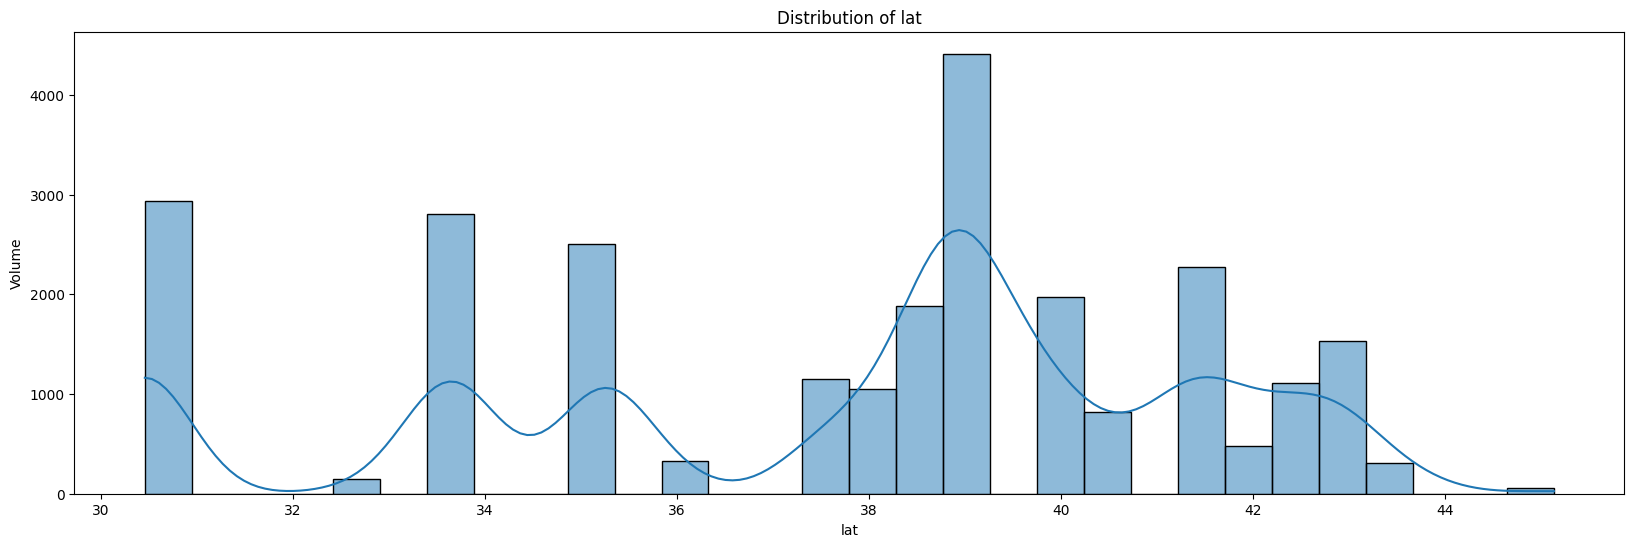

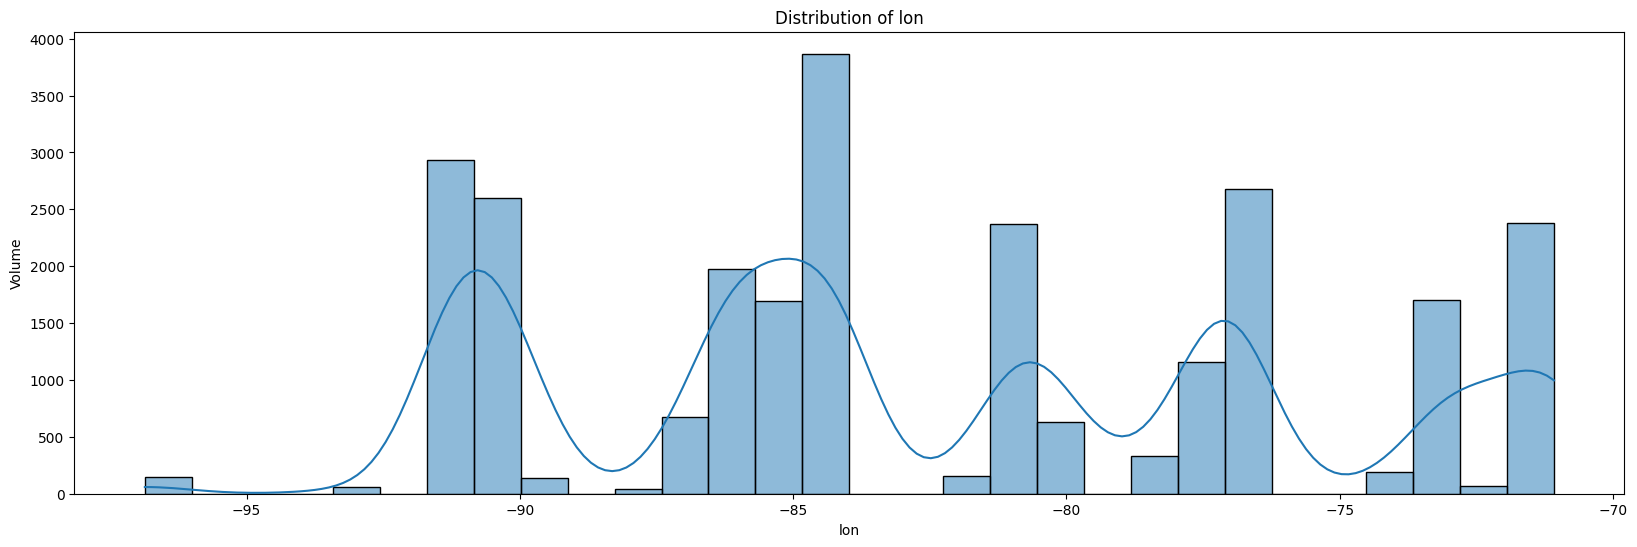

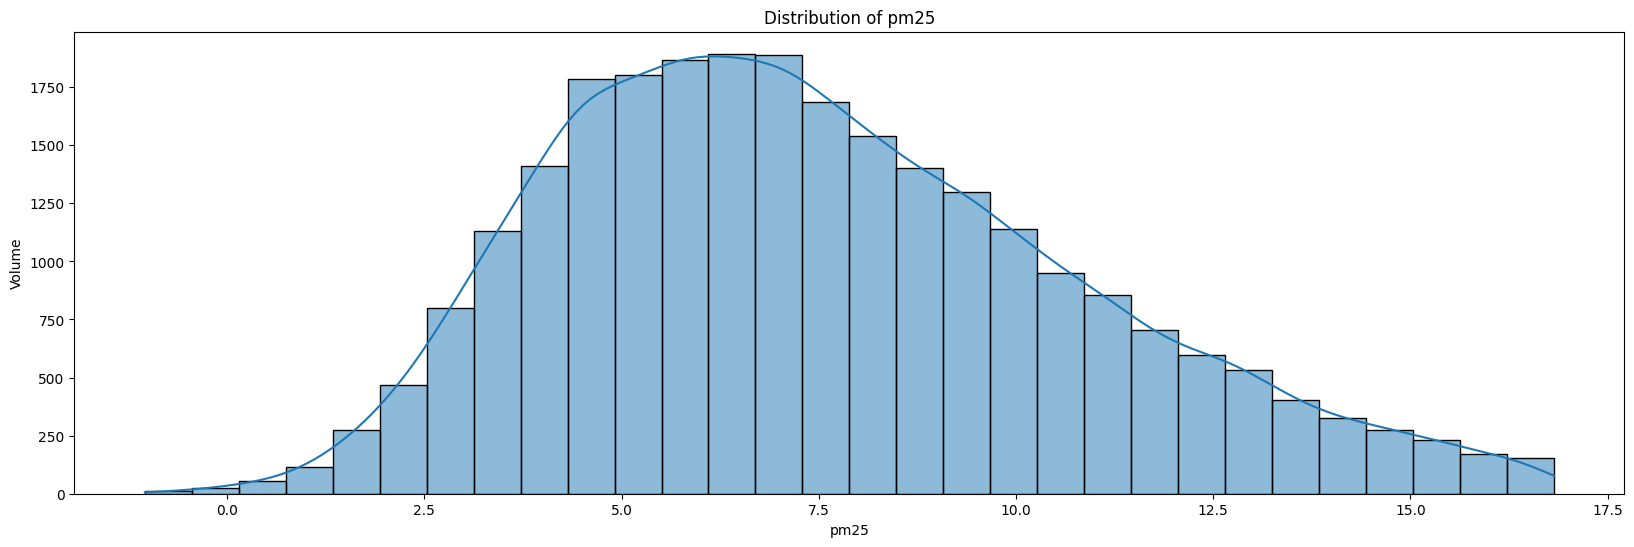

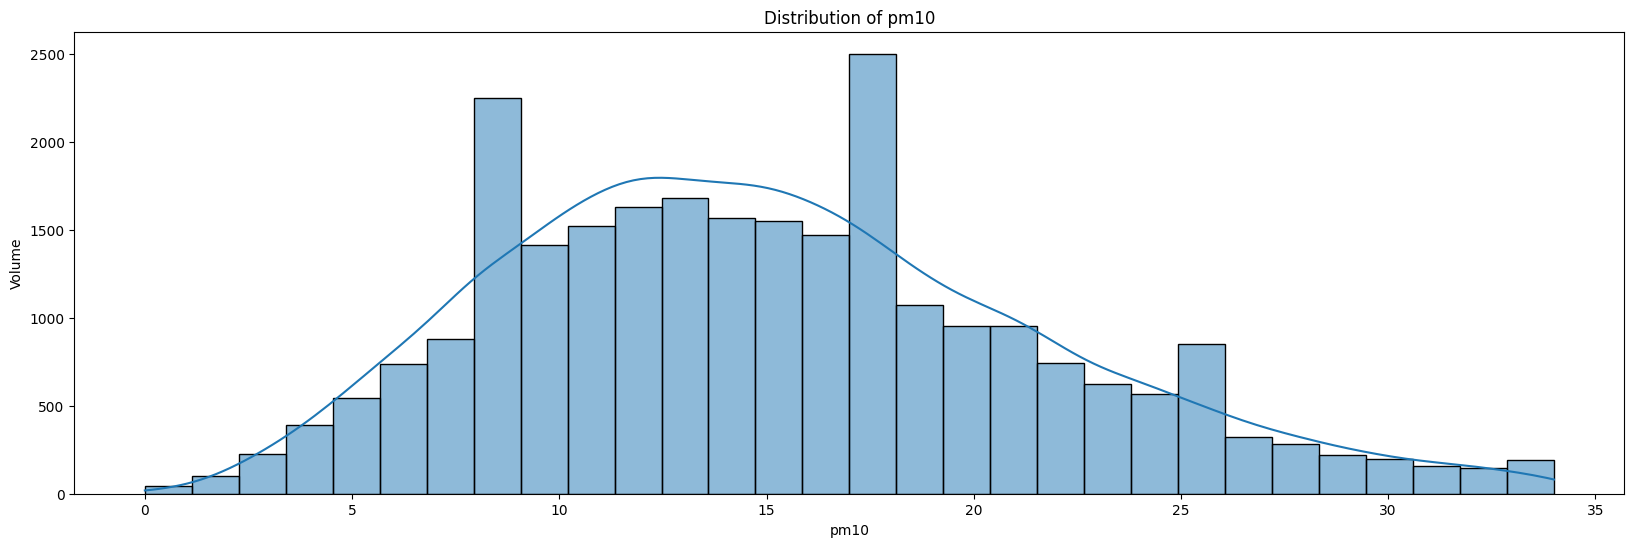

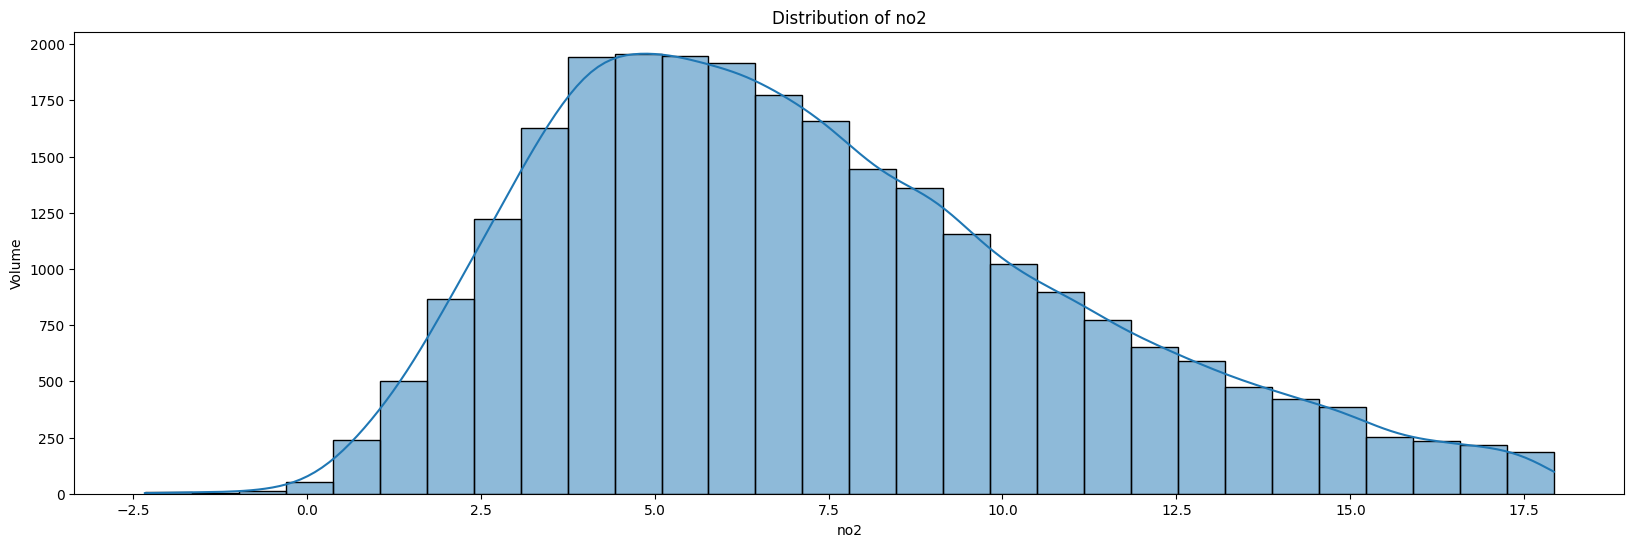

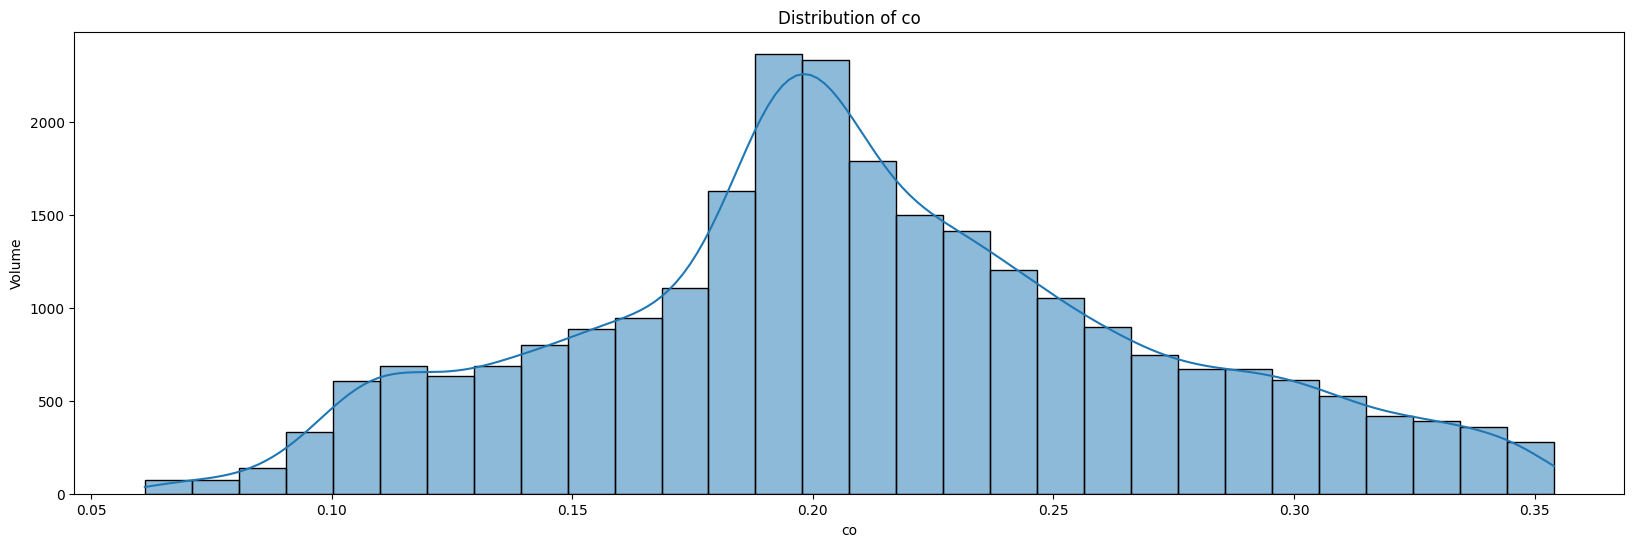

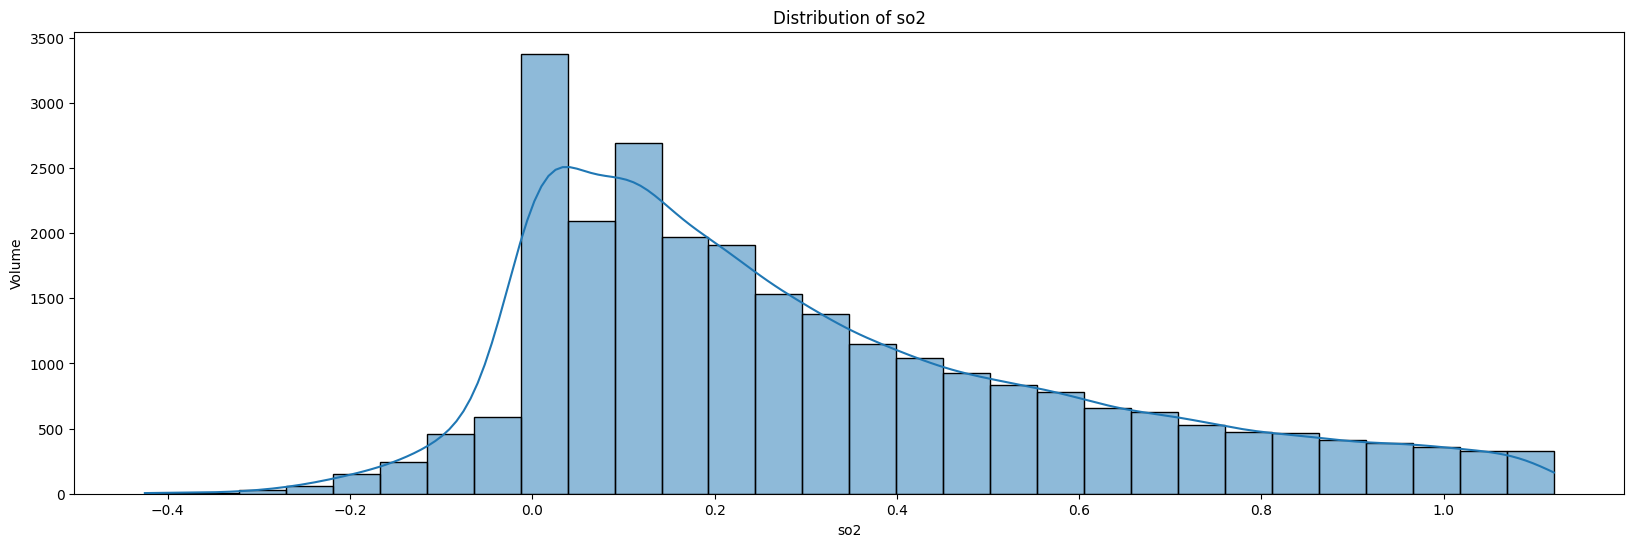

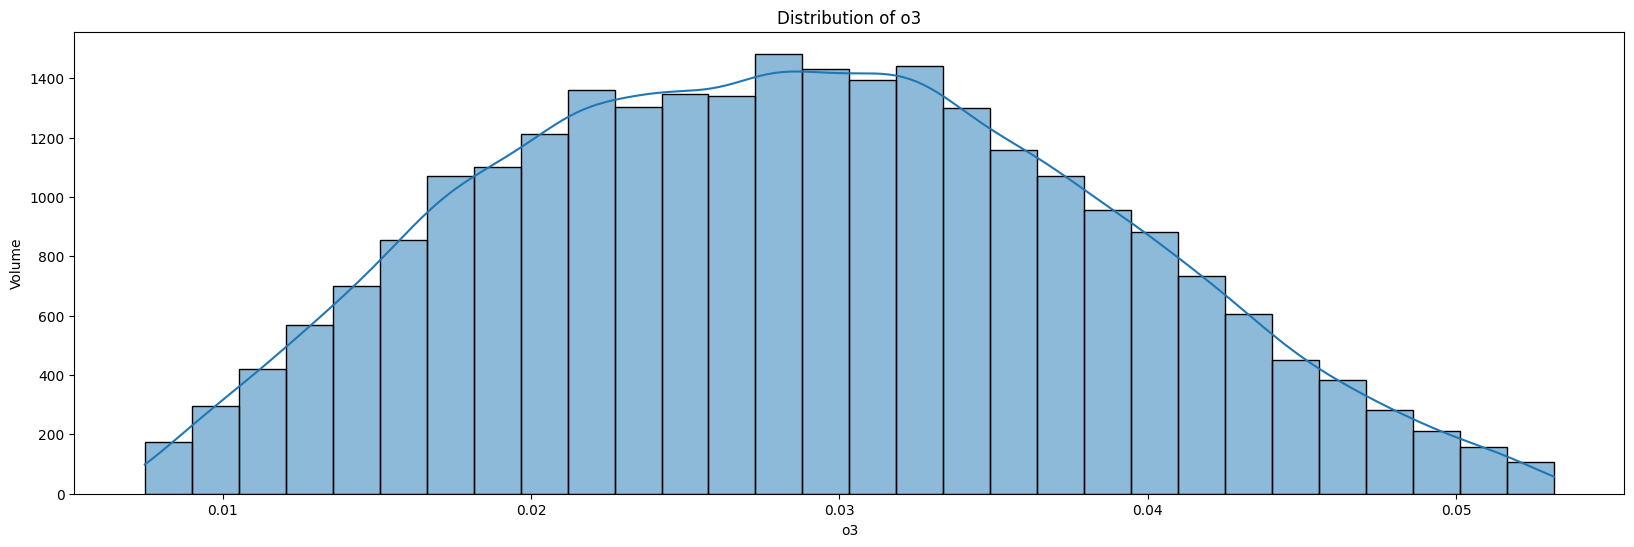

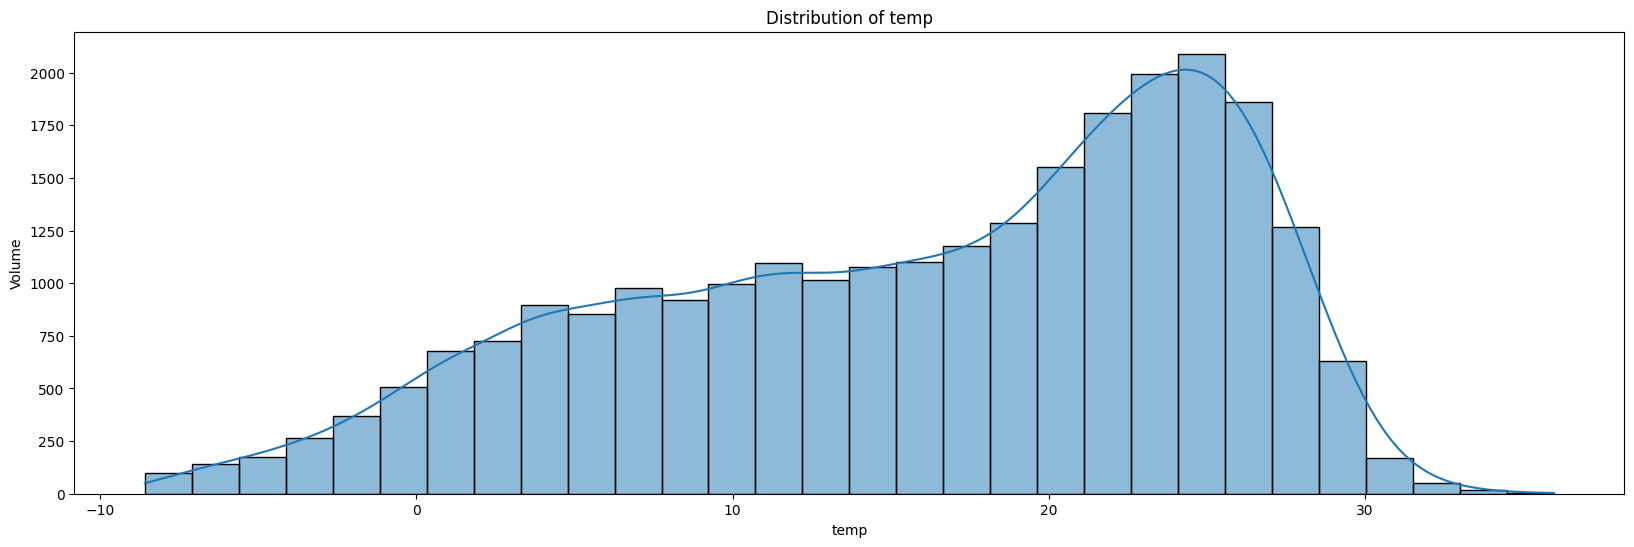

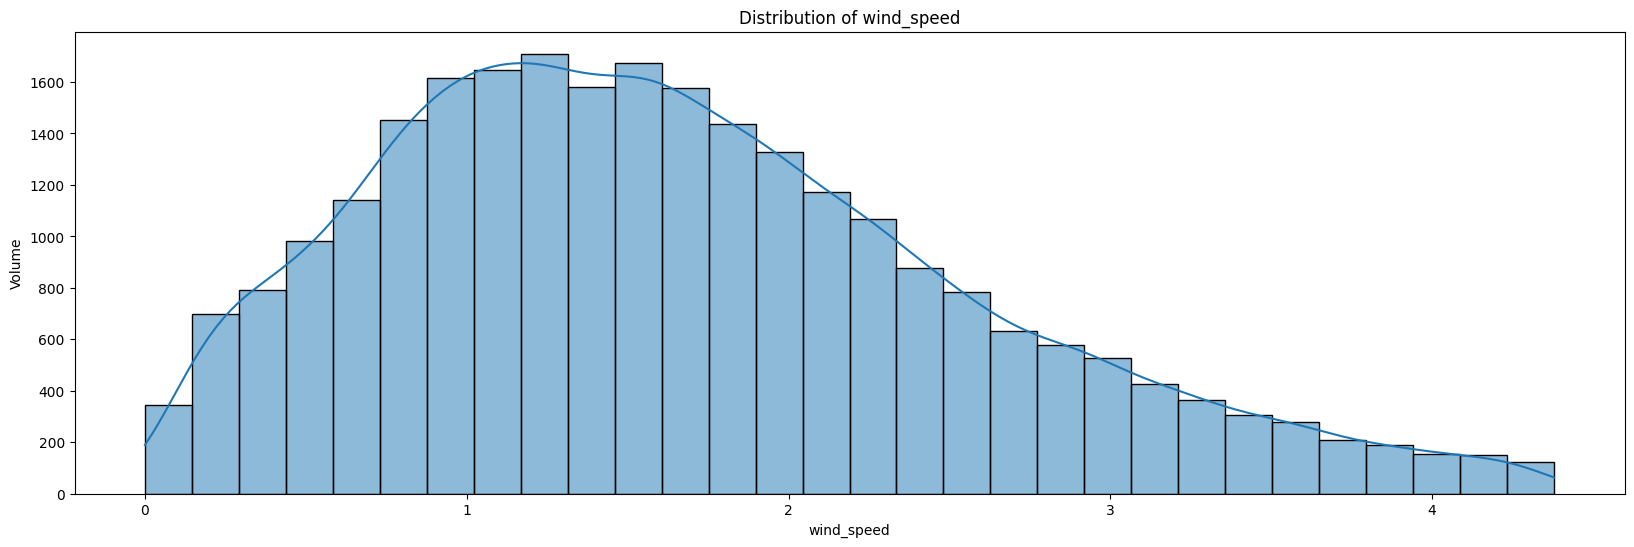

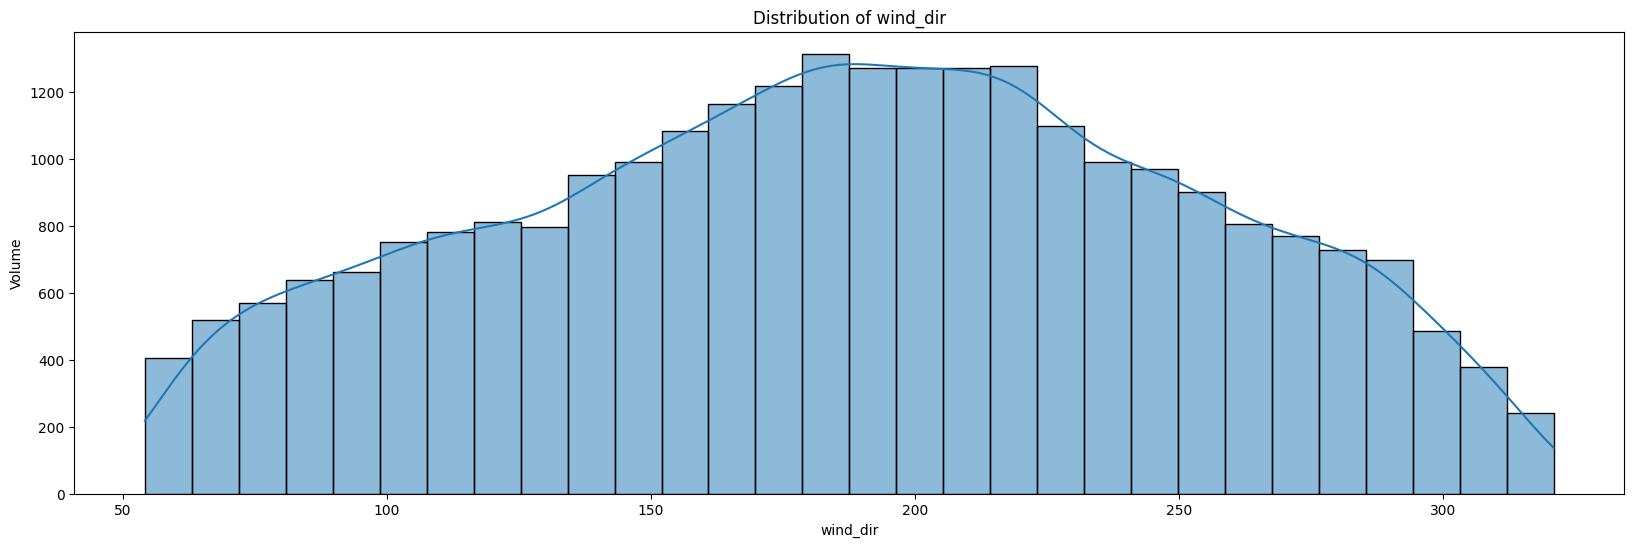

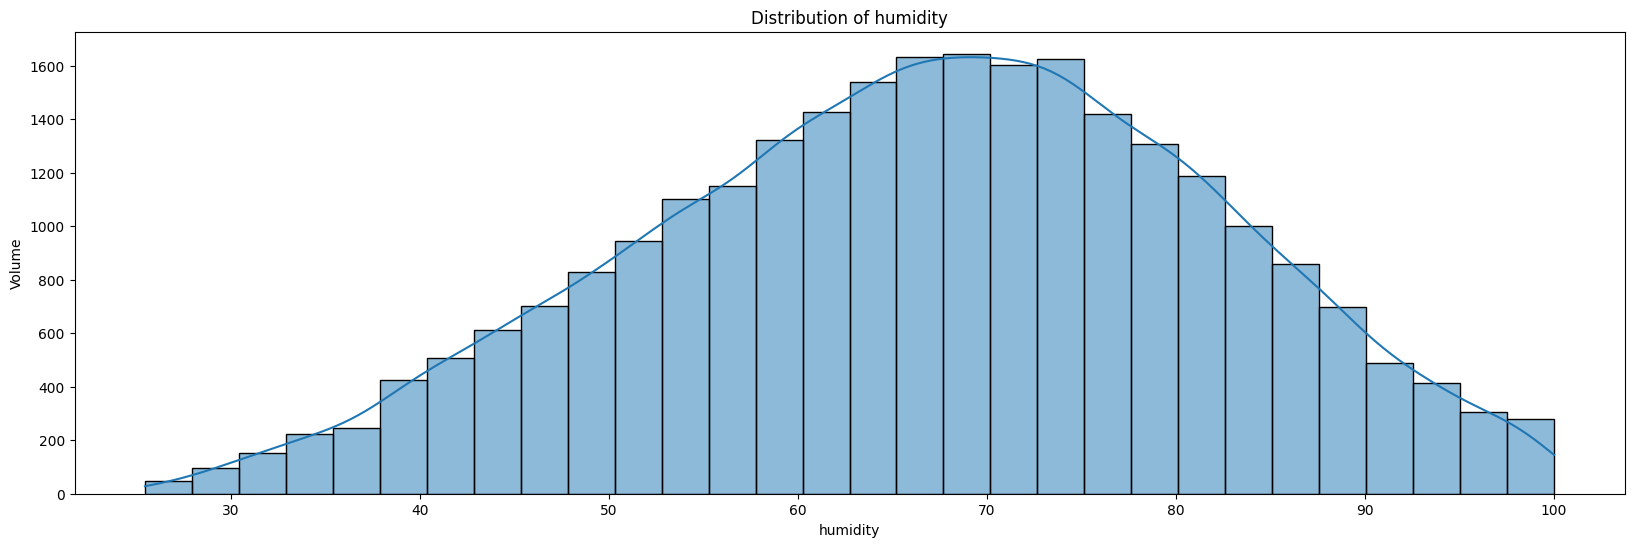

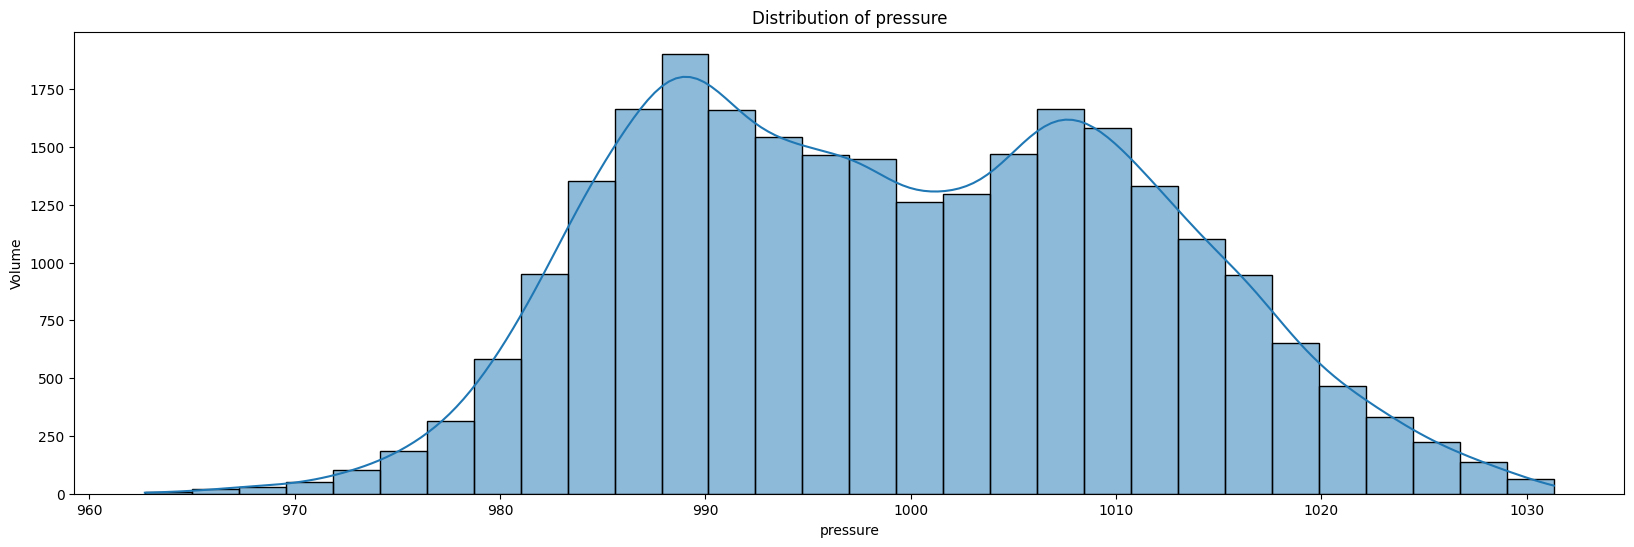

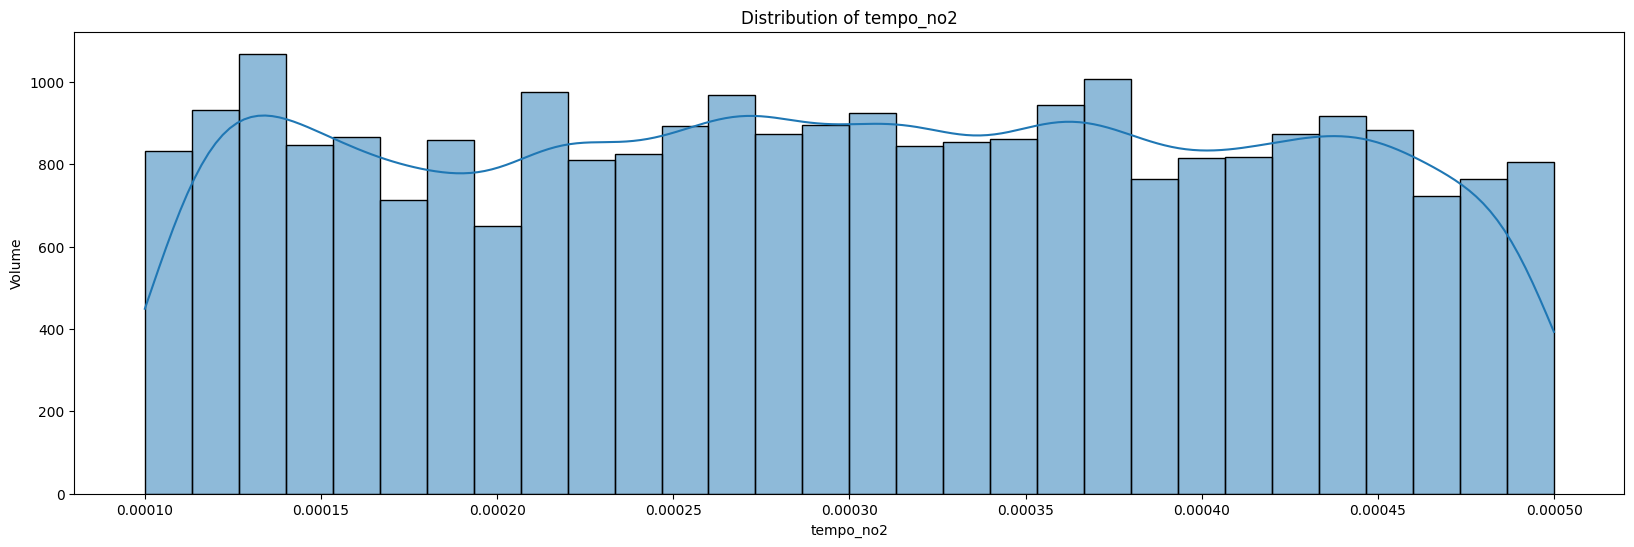

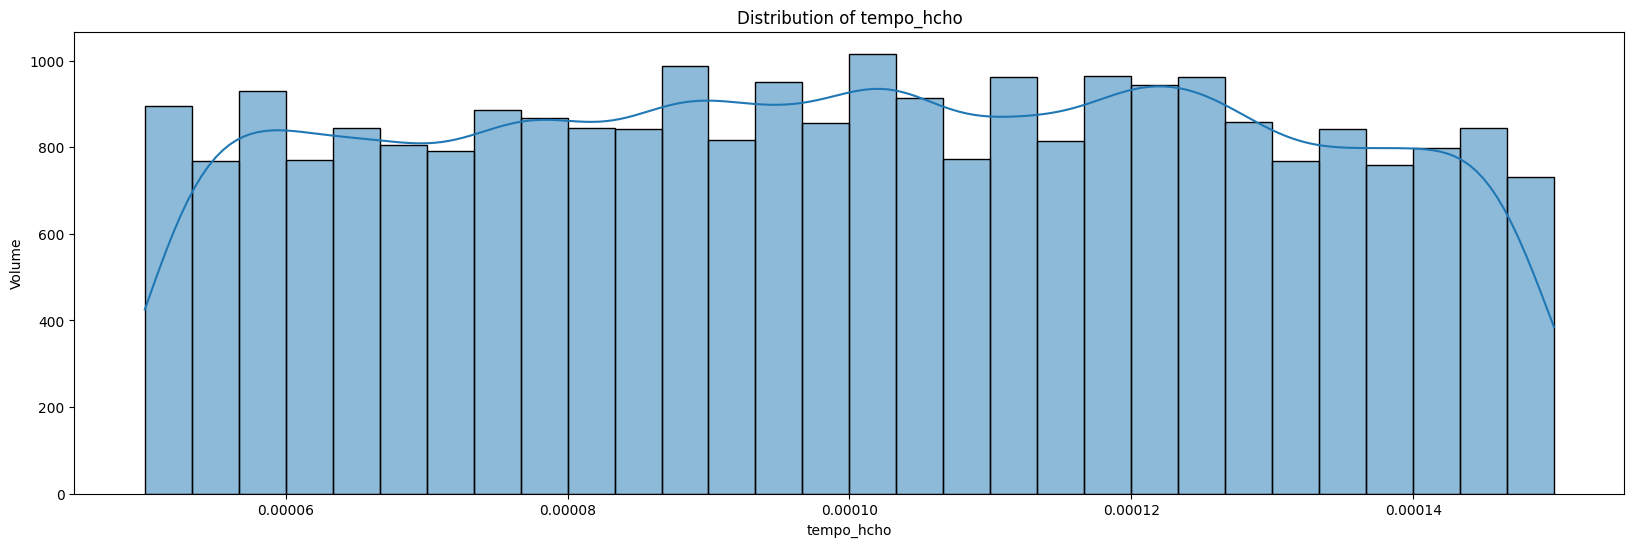

In [259]:
_plot_dis(df)

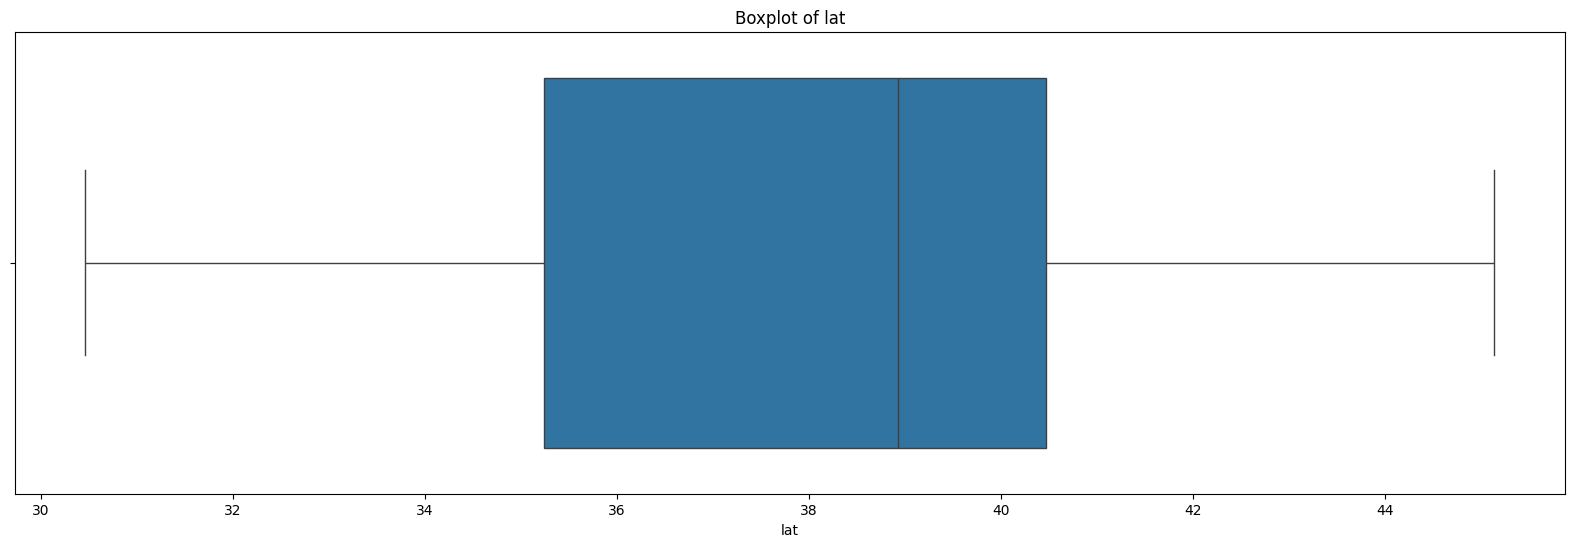

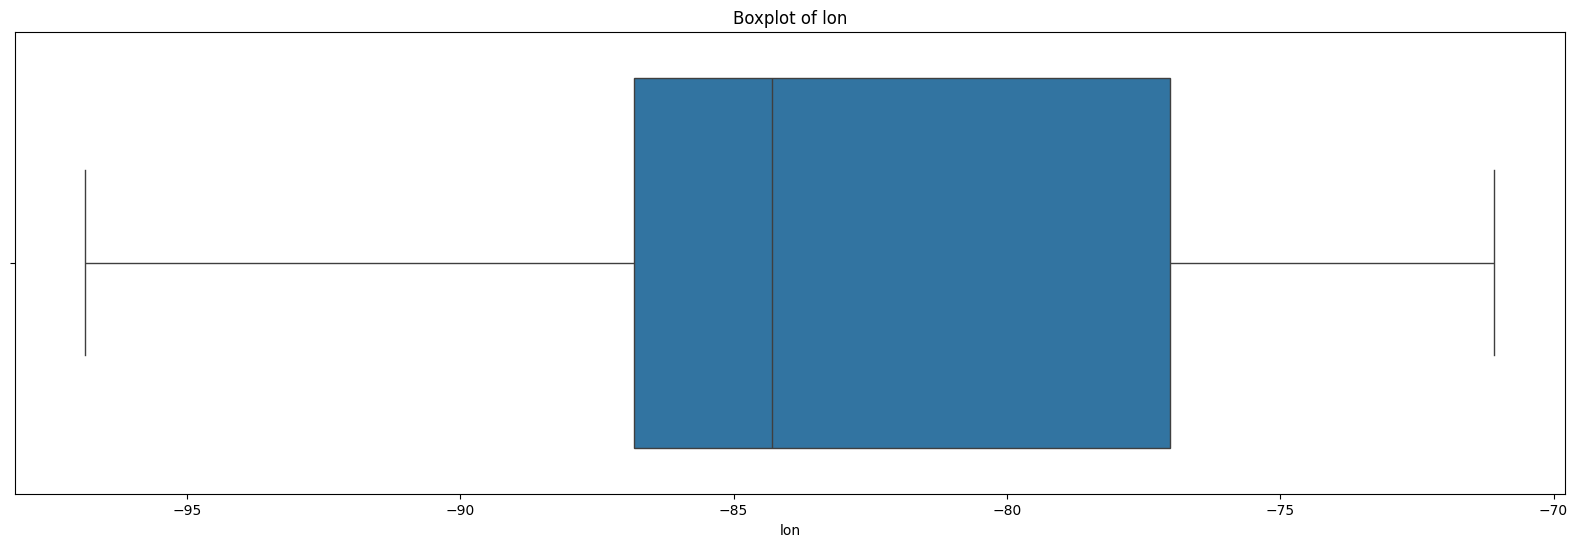

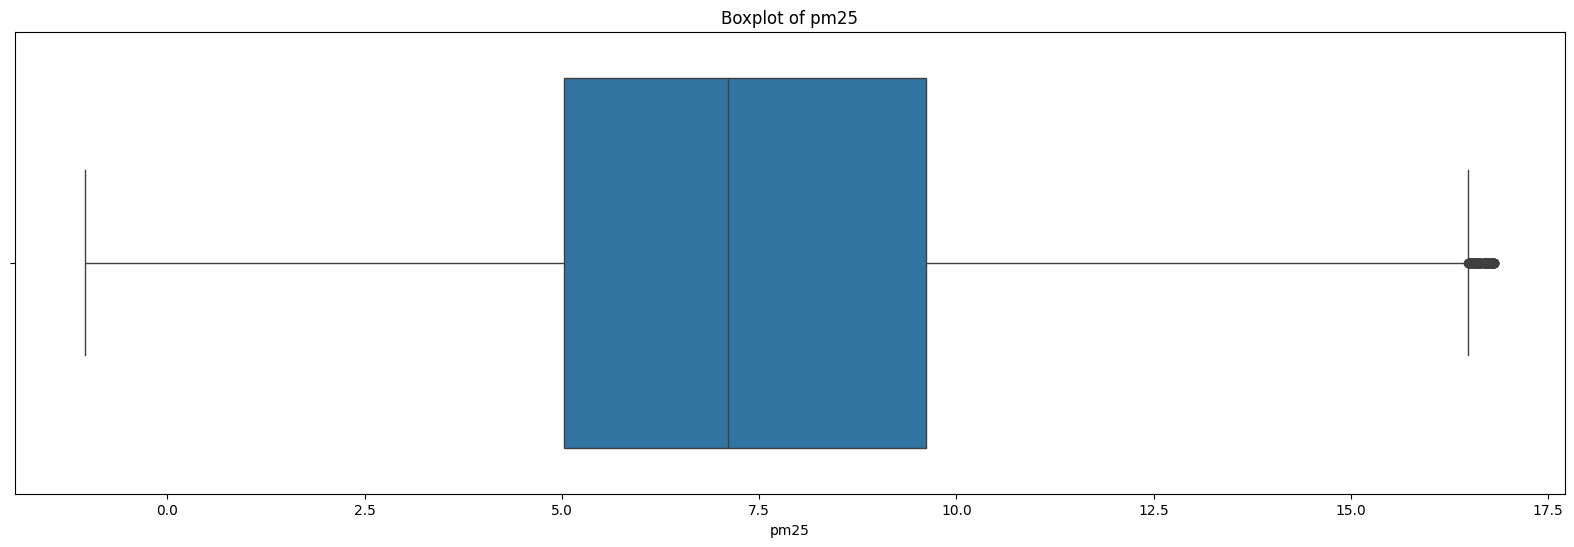

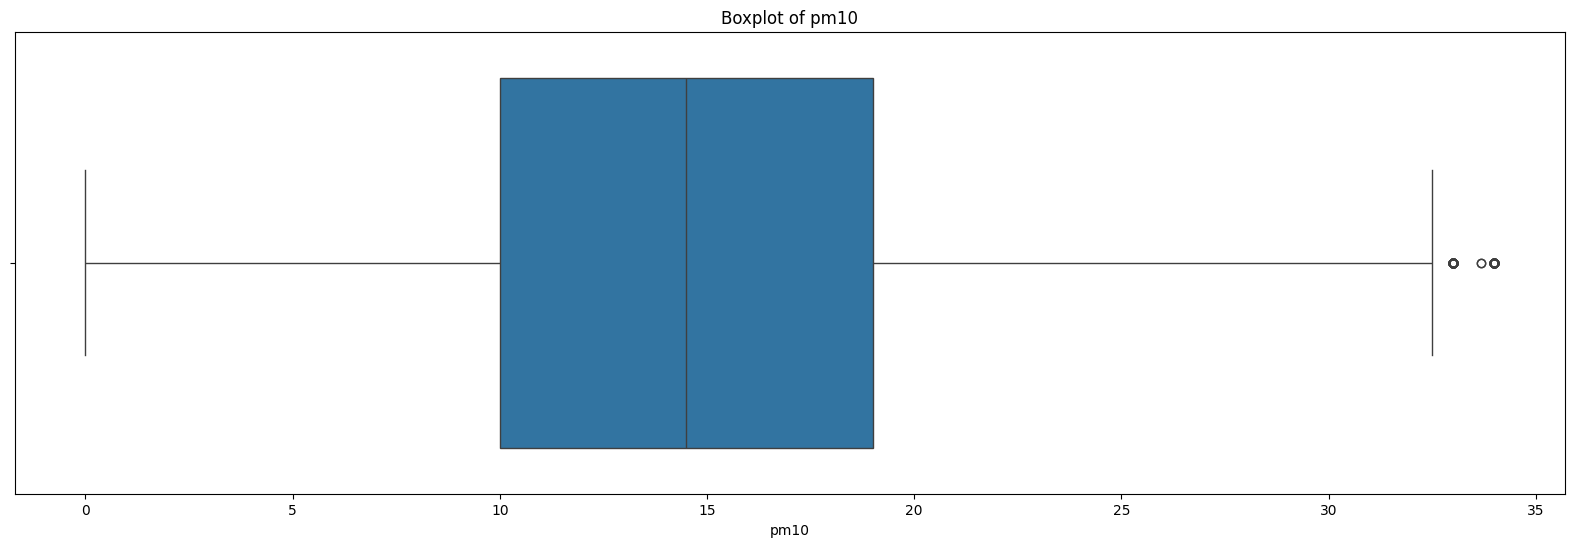

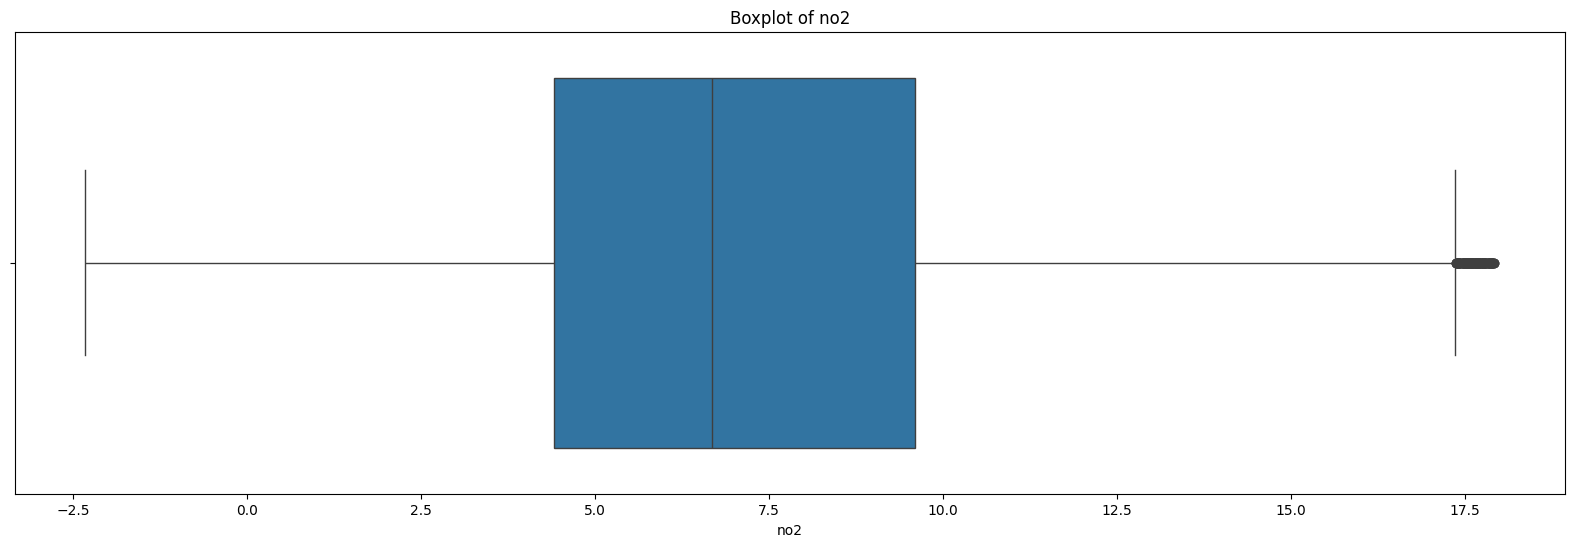

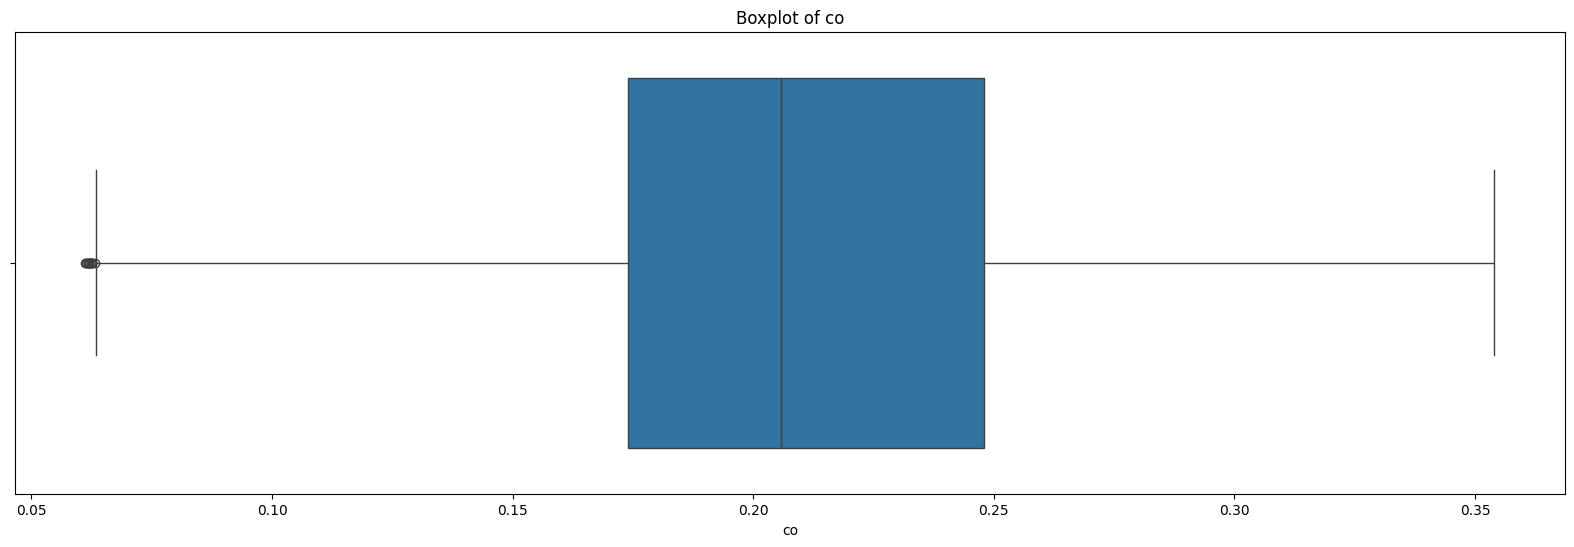

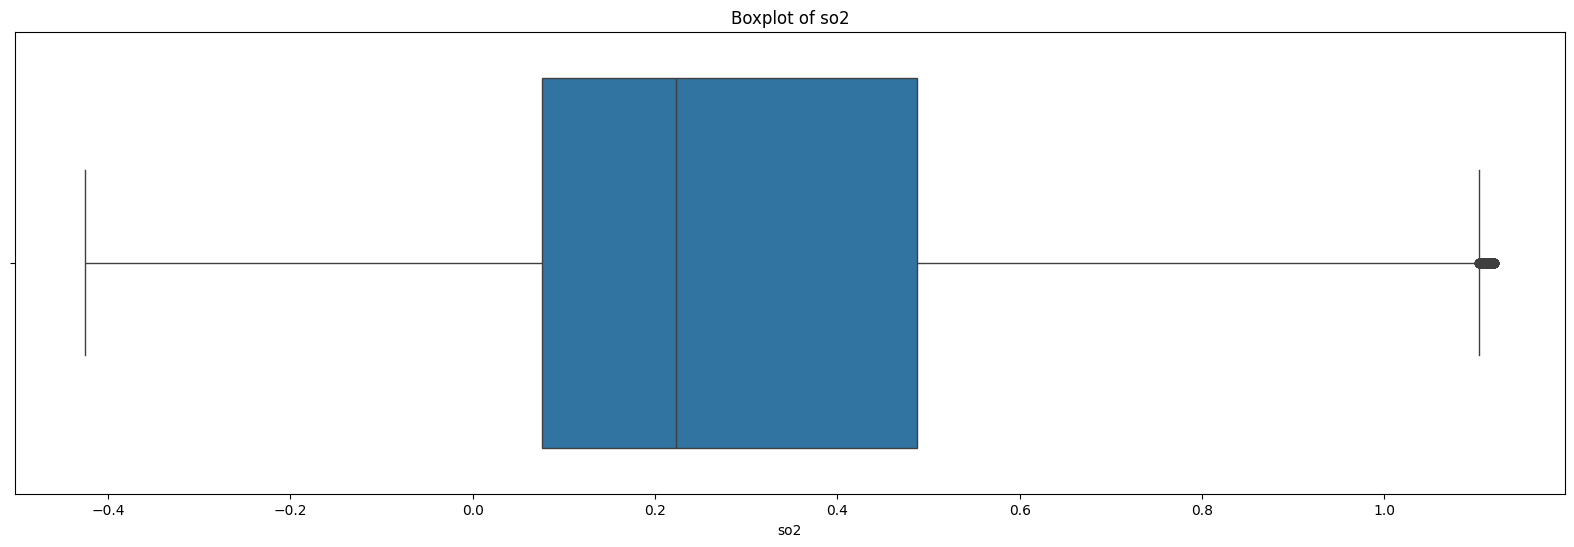

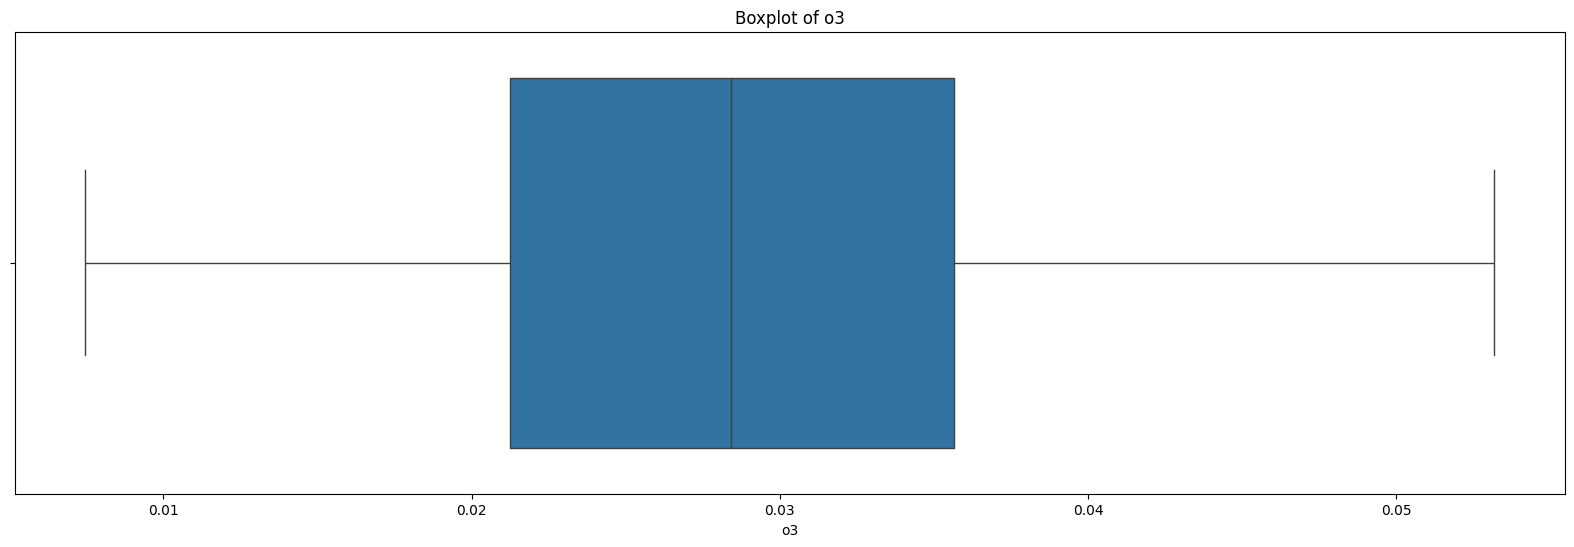

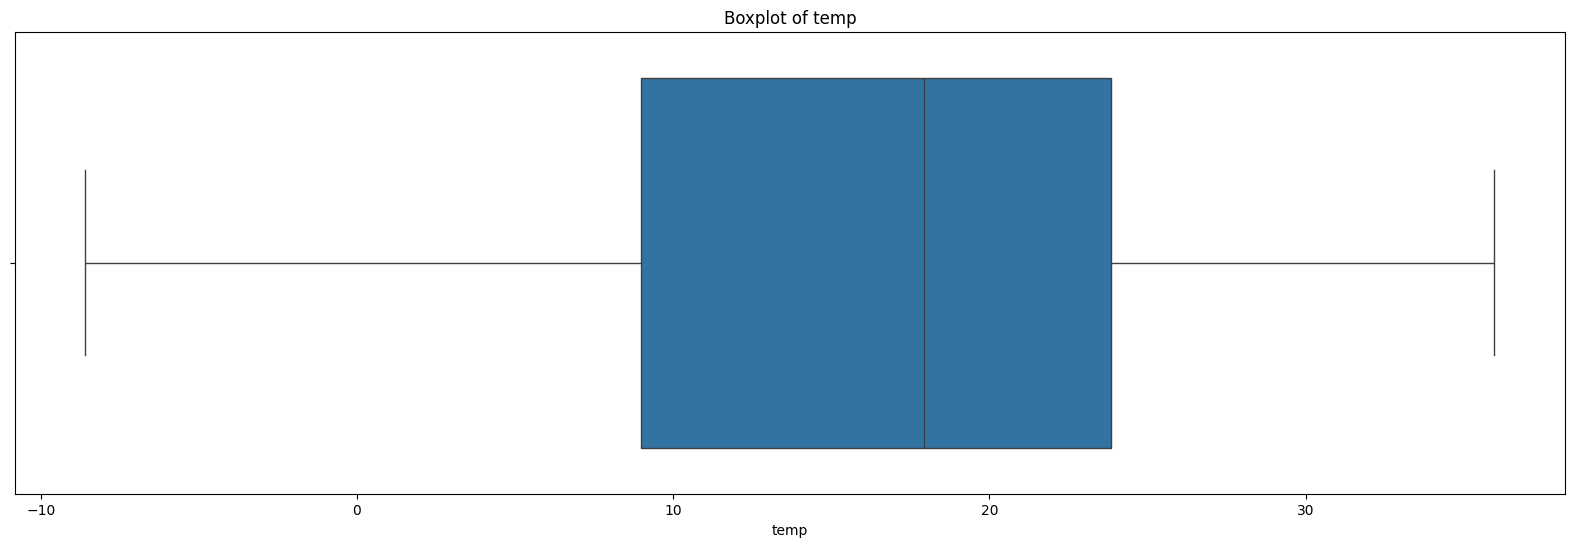

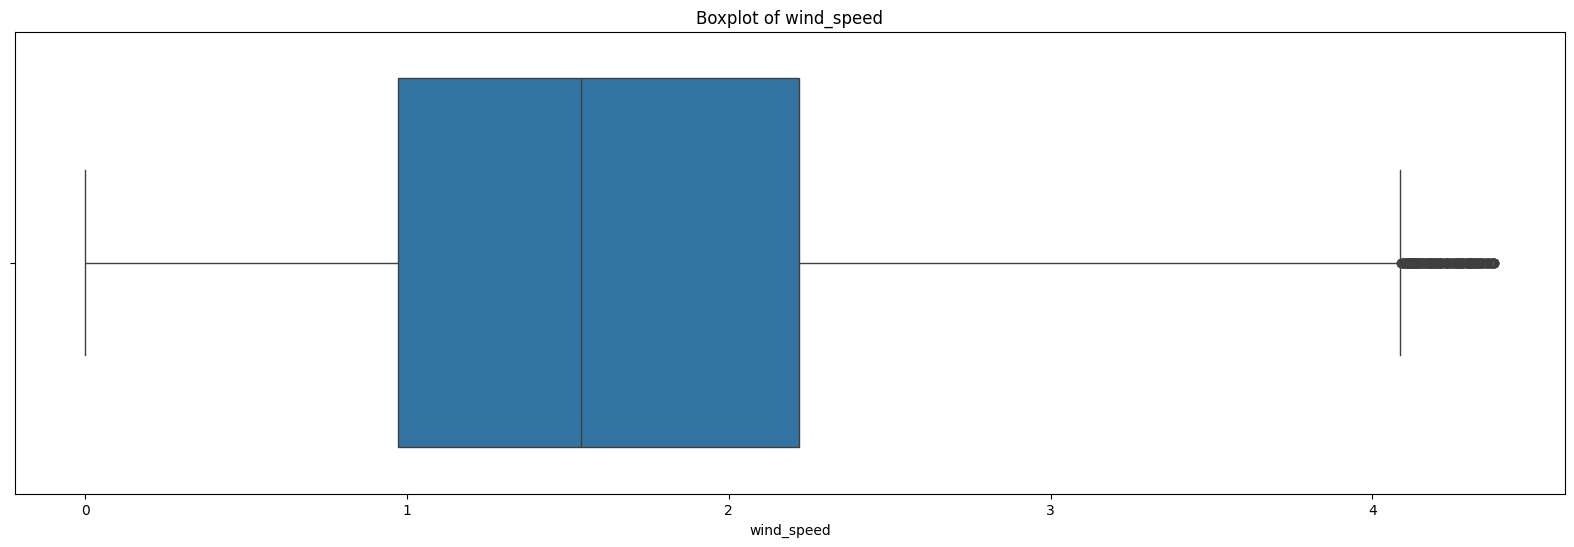

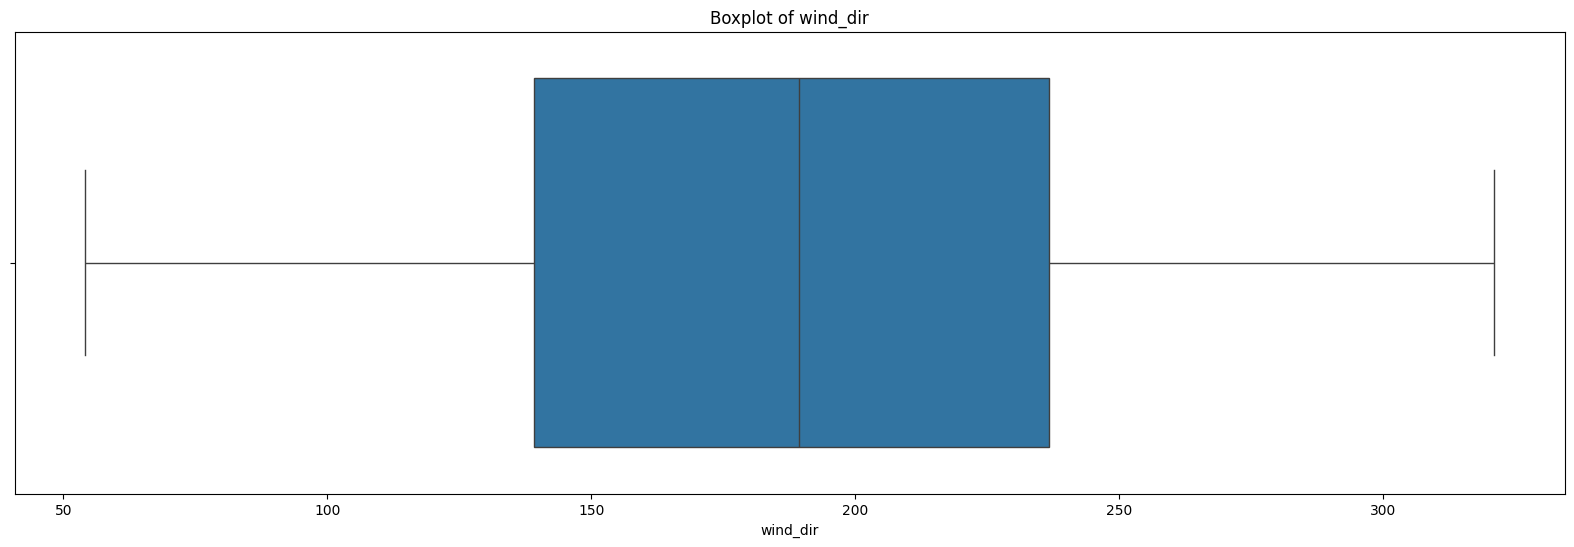

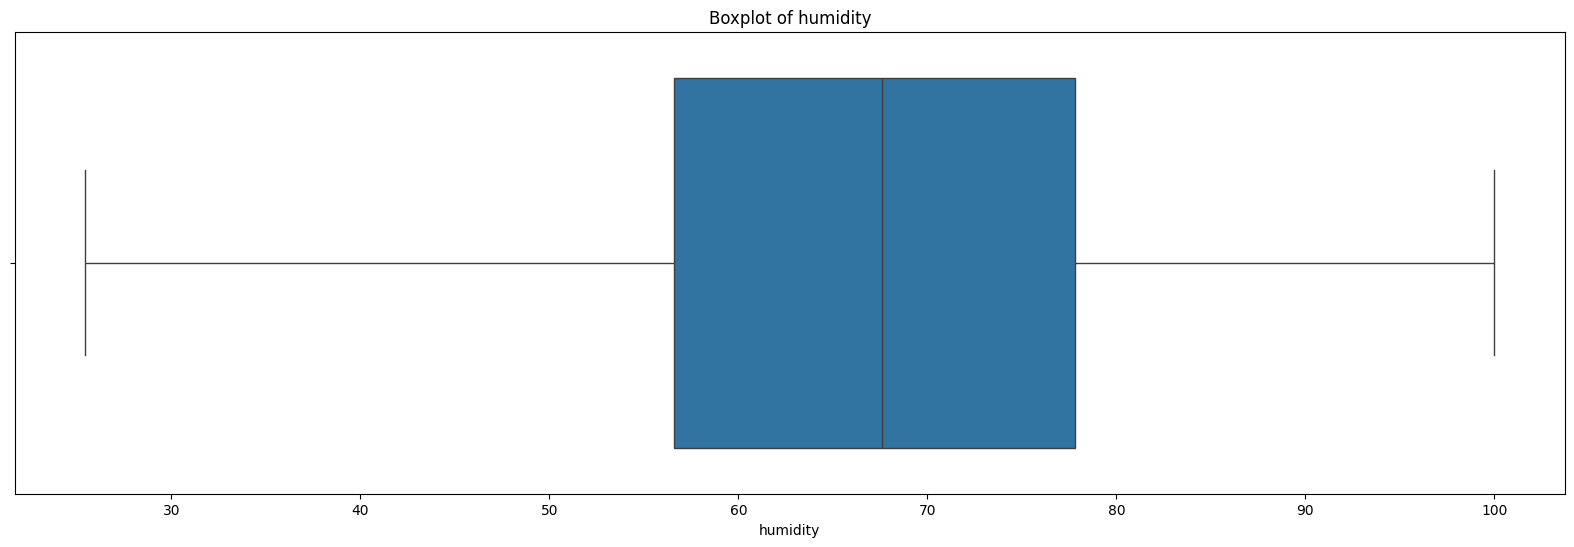

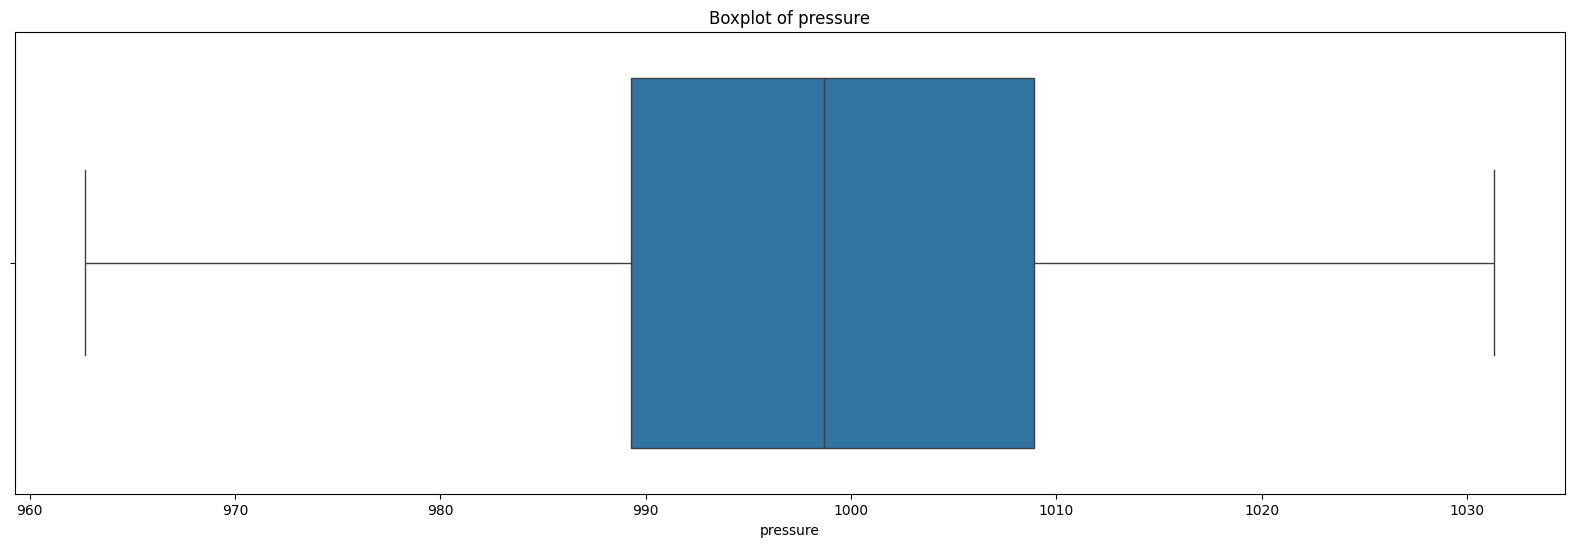

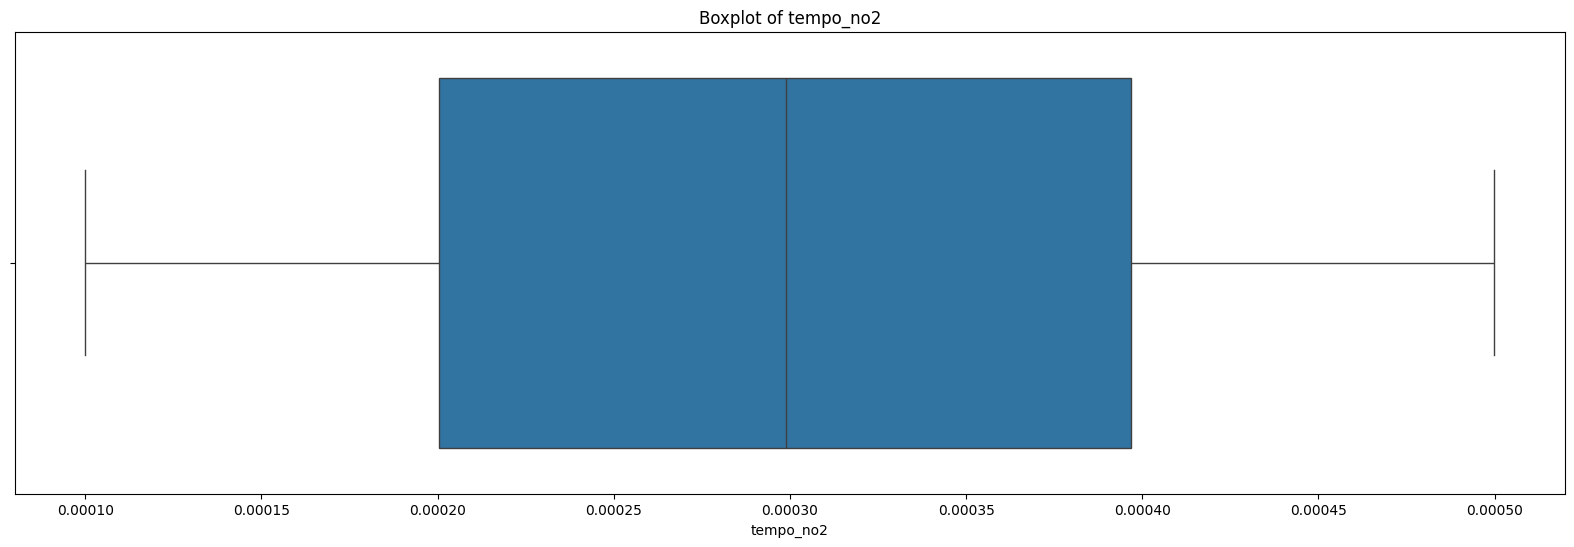

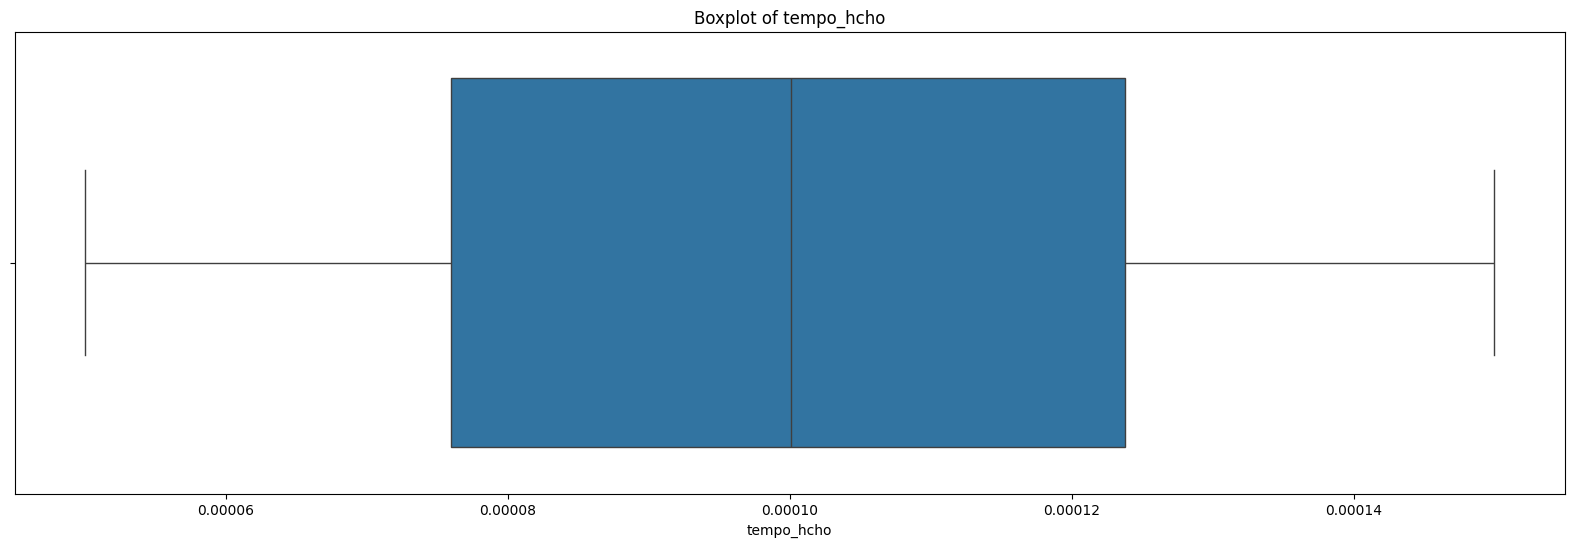

In [260]:
_box_plot(df)

# **4. Preprocessing**

## **4.1 Standardize longitude and latitude**

In [342]:
def standardize_coor(df):
    df['lat_rad'] = np.radians(df['lat'])
    df['lon_rad'] = np.radians(df['lon'])

    df['x'] = np.cos(df['lat_rad']) * np.cos(df['lon_rad'])
    df['y'] = np.cos(df['lat_rad']) * np.sin(df['lon_rad'])
    df['z'] = np.sin(df['lat_rad'])

In [343]:
standardize_coor(df)

In [344]:
df.columns

Index(['date', 'lat', 'lon', 'pm25', 'pm10', 'no2', 'co', 'so2', 'o3', 'temp',
       'wind_speed', 'wind_dir', 'humidity', 'pressure', 'tempo_no2',
       'tempo_hcho', 'lat_rad', 'lon_rad', 'x', 'y', 'z'],
      dtype='object')

In [345]:
df.drop(columns=['lon_rad', 'lat_rad', 'temp', 'wind_speed', 'wind_dir', 'humidity', 'pressure', 'tempo_no2', 'tempo_hcho'], inplace=True)

In [312]:
df.describe()

,lat,lon,pm25,pm10,no2,co,so2,o3,x,y,z
count,25797.000000,25797.000000,25797.000000,25797.000000,25797.000000,25797.000000,25797.000000,25797.000000,25797.000000,25797.000000,25797.000000
mean,37.709525,-82.473956,7.502252,15.125139,7.272828,0.210627,0.306296,0.028616,0.100180,-0.777923,0.610367
std,3.754716,6.533943,3.281352,6.504761,3.746166,0.059510,0.300350,0.009682,0.085052,0.047579,0.052495
min,30.461981,-96.860117,-1.041667,0.000000,-2.326667,0.061187,-0.425000,0.007471,-0.100379,-0.861783,0.506967
25%,35.240100,-86.815000,5.030556,10.000000,4.416667,0.174007,0.076397,0.021235,0.046302,-0.806202,0.577004
50%,38.921847,-84.290500,7.100000,14.500000,6.678261,0.205834,0.222916,0.028412,0.082778,-0.772163,0.628260
75%,40.465420,-77.013178,9.612500,19.000000,9.597917,0.247871,0.487500,0.035647,0.174838,-0.749149,0.648989
max,45.137680,-71.082600,16.818750,34.000000,17.926087,0.354032,1.120834,0.053176,0.239680,-0.692373,0.708804


## **4.2 Calculate AQI**

In [346]:
target_columns = ['pm25', 'pm10', 'no2', 'co', 'o3']
# target_columns = ['pm25', 'pm10', 'no2', 'co', 'so2', 'o3', 'temp', 'wind_speed', 'wind_dir', 'humidity', 'pressure', 'tempo_no2', 'tempo_hcho']

def calculate_aqi(df):
    df['AQI_Total'] = df[target_columns].max(axis=1)
    return df

In [347]:
calculate_aqi(df)

,date,lat,lon,pm25,pm10,no2,co,so2,o3,x,y,z,AQI_Total
115,2017-01-15,30.461981,-91.179219,7.779167,15.0,12.166667,0.199025,0.102083,0.024353,-0.017739,-0.861783,0.506967,15.000000
116,2017-01-16,30.461981,-91.179219,6.927778,12.0,9.395238,0.199500,0.102083,0.025059,-0.017739,-0.861783,0.506967,12.000000
117,2017-01-17,30.461981,-91.179219,7.930556,21.0,10.212500,0.207396,0.100000,0.020706,-0.017739,-0.861783,0.506967,21.000000
118,2017-01-18,30.461981,-91.179219,8.508333,21.0,13.720833,0.246257,0.104166,0.022706,-0.017739,-0.861783,0.506967,21.000000
119,2017-01-19,30.461981,-91.179219,8.916666,23.0,12.768182,0.229375,0.102083,0.015235,-0.017739,-0.861783,0.506967,23.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67779,2012-12-09,41.530011,-90.587611,12.900000,13.0,6.540909,0.191591,0.489752,0.012000,-0.007677,-0.748569,0.663012,13.000000
67780,2012-12-12,41.530011,-90.587611,7.900000,17.0,11.400000,0.202125,1.083333,0.022471,-0.007677,-0.748569,0.663012,17.000000
67781,2012-12-15,41.530011,-90.587611,11.100000,22.0,17.079167,0.209313,0.164583,0.014824,-0.007677,-0.748569,0.663012,22.000000
67782,2012-12-18,41.530011,-90.587611,15.300000,16.0,7.816667,0.204541,0.322916,0.011176,-0.007677,-0.748569,0.663012,16.000000


## **4.2 Remove no need columns**

In [315]:
df.columns

Index(['date', 'lat', 'lon', 'pm25', 'pm10', 'no2', 'co', 'so2', 'o3', 'x',
       'y', 'z', 'AQI_Total'],
      dtype='object')

In [348]:
# df.drop(columns=['target_pm25', 'longitude', 'latitude', 'target_pm25', 'pm25_lag_1d', 'pm10_lag_1d', 'no2_lag_1d', 'co', 'so2', 'o3'], inplace=True)
df.drop(columns=['lon', 'lat'], inplace=True)

## **4.3 Min max scaler**

In [ ]:
import joblib
from sklearn.preprocessing import MinMaxScaler

exclude_cols = ['date']

def __min_max_scaler(df, save_path='scaler.pkl'):
    cols_to_scale = [c for c in df.columns if c not in exclude_cols]  # list str
    scaler = MinMaxScaler()
    scaler.fit(df[cols_to_scale].to_numpy())  # fit chỉ với numeric
    joblib.dump(scaler, save_path)

    print(f"✅ Scaler saved to {save_path}")

    return df_scaled, scaler

In [350]:
# df_scaled, _ = __min_max_scaler(df)
df_scaled = df

In [335]:
df_scaled

,date,pm25,pm10,no2,co,so2,o3,x,y,z,AQI_Total
date,,,,,,,,,,,
2025-01-02,2025-01-02,0.195264,0.117647,0.267196,0.401450,0.474394,0.401553,0.803712,0.520168,0.508217,0.090909
2025-01-02,2025-01-02,0.217835,0.147059,0.299630,0.583785,0.340970,0.114539,0.538606,0.199744,0.236333,0.121212
2025-01-02,2025-01-02,0.381010,0.235294,0.452490,0.706645,0.708895,0.258681,0.287233,0.477433,0.583056,0.212121
2025-01-02,2025-01-02,0.314864,0.161765,0.237293,0.299764,0.417755,0.337184,0.448255,0.563049,0.660375,0.136364
2025-01-02,2025-01-02,0.165325,0.088235,0.268770,0.282004,0.290804,0.253539,0.685186,0.664860,0.703648,0.064141
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-28,2025-06-28,0.252980,0.323529,0.253369,0.396404,0.274933,0.650585,0.272606,0.668282,0.773126,0.303030
2025-06-28,2025-06-28,0.573723,0.323529,0.378769,0.515425,0.274933,0.416978,0.679772,0.328084,0.347000,0.303030
2025-06-28,2025-06-28,0.233640,0.176471,0.301893,0.457534,0.652291,0.467192,0.378918,0.713193,0.812426,0.151515


## **4.5 Sort by date**

In [351]:
df_scaled["date"] = pd.to_datetime(df_scaled["date"], errors="coerce")
df_scaled = df_scaled.sort_values("date").reset_index(drop=True)

assert df_scaled["date"].is_monotonic_increasing
df_scaled.index = pd.to_datetime(df_scaled['date'], format='%Y-%m-%d')

In [352]:
df.to_csv("scaled_sorted.csv", index=False)

In [332]:
df_scaled = df_scaled[df_scaled['date'] > '2010-01-01']

In [334]:
df_scaled

,date,pm25,pm10,no2,co,so2,o3,x,y,z,AQI_Total
date,,,,,,,,,,,
2025-01-02,2025-01-02,0.195264,0.117647,0.267196,0.401450,0.474394,0.401553,0.803712,0.520168,0.508217,0.090909
2025-01-02,2025-01-02,0.217835,0.147059,0.299630,0.583785,0.340970,0.114539,0.538606,0.199744,0.236333,0.121212
2025-01-02,2025-01-02,0.381010,0.235294,0.452490,0.706645,0.708895,0.258681,0.287233,0.477433,0.583056,0.212121
2025-01-02,2025-01-02,0.314864,0.161765,0.237293,0.299764,0.417755,0.337184,0.448255,0.563049,0.660375,0.136364
2025-01-02,2025-01-02,0.165325,0.088235,0.268770,0.282004,0.290804,0.253539,0.685186,0.664860,0.703648,0.064141
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-28,2025-06-28,0.252980,0.323529,0.253369,0.396404,0.274933,0.650585,0.272606,0.668282,0.773126,0.303030
2025-06-28,2025-06-28,0.573723,0.323529,0.378769,0.515425,0.274933,0.416978,0.679772,0.328084,0.347000,0.303030
2025-06-28,2025-06-28,0.233640,0.176471,0.301893,0.457534,0.652291,0.467192,0.378918,0.713193,0.812426,0.151515


## **4.6 Data splitting**

In [353]:
target_col = "AQI_Total"

def create_sequences(data, target_col, lookback):
    X, y, dates = [], [], []
    for i in range(len(data) - lookback):
        seq_X = data.iloc[i:i+lookback].drop(columns=['date', target_col]).values
        seq_y = data.iloc[i+lookback][target_col]
        seq_date = data.iloc[i+lookback]['date']
        X.append(seq_X)
        y.append(seq_y)
        dates.append(seq_date)
    return np.array(X), np.array(y), np.array(dates)

In [354]:
lookback = 7
X, y, dates = create_sequences(df_scaled, target_col, lookback)

In [355]:
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates, test_size=0.2, shuffle=False
)

# **5. Training**

## **5.1 Hyperparam config**

In [356]:
wandb.init(project="NASA_AIR_QUALITY_FORECASTING", name="lstm_v2_simpleaqi_unit64_drop_d02ense32relu_dense1_batch32_1e-5",     config={
        "model": "LSTM",
        "units": 64,
        "dropout": 0.2,
        "batch_size": 32,
        "epochs": 50,
        "dense_units": 32,
        "loss": "mse",
        "optimizer": "adam",
        "learning_rate": 1e-5
    })

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▆▆▅▅▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▅▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,49
best_val_loss,0.03547
epoch,49
loss,0.03495
val_loss,0.03547


## **5.2 Training**

In [357]:
config = wandb.config
model = Sequential([
    LSTM(config.units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(config.dropout),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=config.learning_rate)
model.compile(optimizer=optimizer, loss='mse')

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=config.epochs,
    batch_size=config.batch_size,
    validation_data=(X_test, y_test),
    callbacks=[
        WandbCallback(save_model=False, save_weights_only=False, save_graph=False),
        early_stop
    ],
    verbose=1
)

Epoch 1/50


/home/nguyen-quang-huy/GITHUB/My_Repo/AirForce/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 271.2705 - val_loss: 222.4208
Epoch 2/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 235.7633 - val_loss: 184.0465
Epoch 3/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 189.9788 - val_loss: 139.7632
Epoch 4/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 140.7283 - val_loss: 98.1298
Epoch 5/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 97.6225 - val_loss: 66.3568
Epoch 6/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 66.7938 - val_loss: 49.1193
Epoch 7/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 50.2510 - val_loss: 42.6055
Epoch 8/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 43.1305 - val_loss: 41.2952
Epoch 9/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 40.5178 - val_loss: 41.7174
Epoch 10/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 39.6106 - val_loss: 42.0562
Epoch 11/50
645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 39.4256 - val_loss: 41.5133
Epoch 12/50
645/645 ━━━━━━━━━━━━━━

## **5.3 True vs Predicted Value**

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


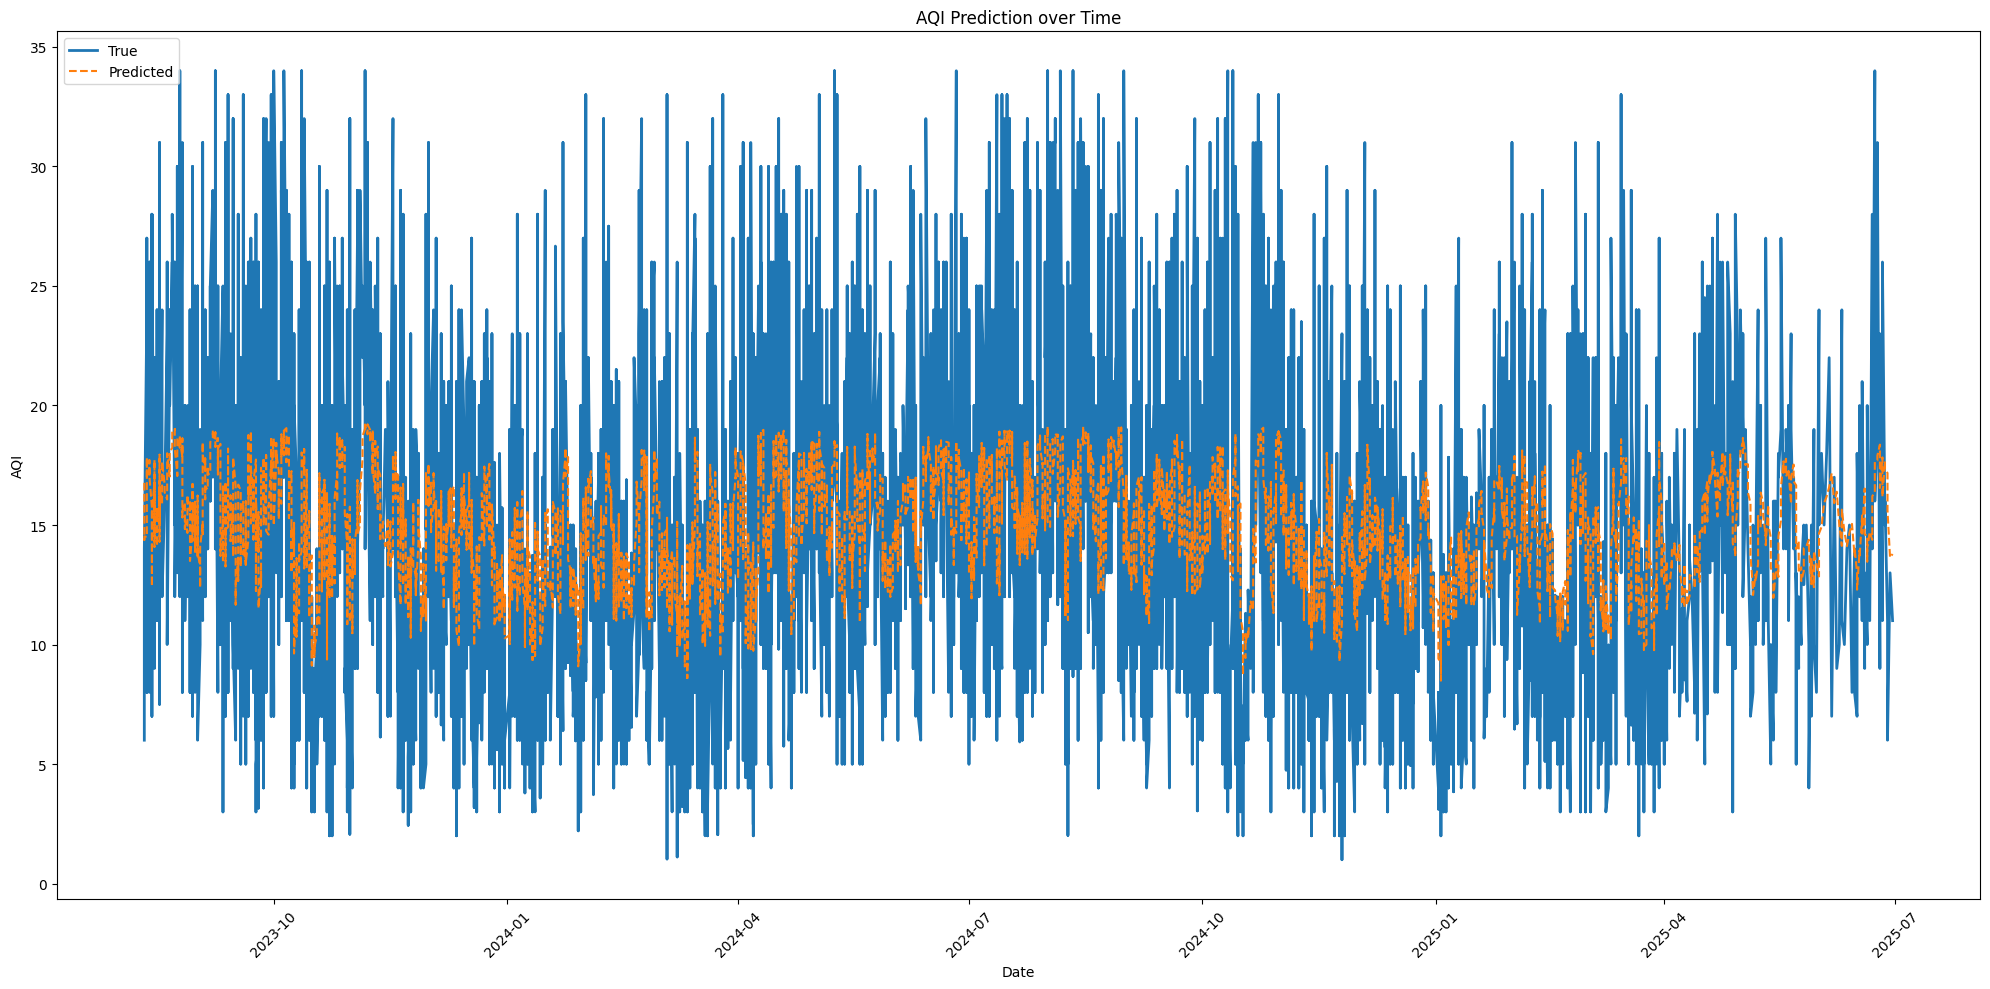

<Figure size 640x480 with 0 Axes>

In [358]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.figure(figsize=(20, 10))
plt.plot(dates_test, y_test, label='True', linewidth=2)
plt.plot(dates_test, y_pred, label='Predicted', linestyle='--')
plt.legend()
plt.title("AQI Prediction over Time")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig("truevspredicted.png", dpi=300, bbox_inches='tight')

## **5.4 Train loss vs Val loss**

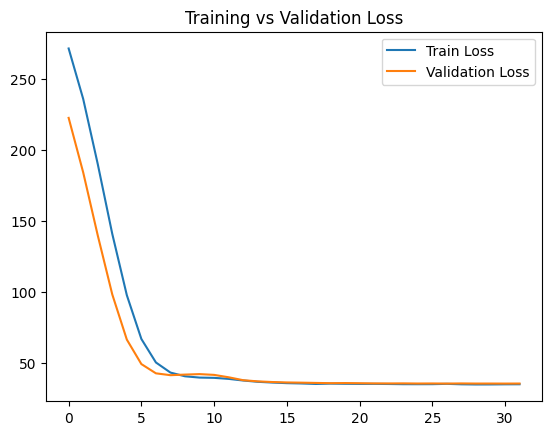

In [359]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")

plt.savefig("loss_curve.png", dpi=300, bbox_inches='tight')

In [360]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.3f}")
print(f"MSE:  {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2 :  {r2:.3f}")


MAE:  4.736
MSE:  35.390
RMSE: 5.949
R2 :  0.138


In [228]:
df_scaled.columns

Index(['date', 'pm25', 'pm10', 'no2', 'co', 'so2', 'o3', 'temp', 'wind_speed',
       'wind_dir', 'humidity', 'pressure', 'tempo_no2', 'tempo_hcho',
       'lat_rad', 'lon_rad', 'x', 'y', 'z', 'AQI_Total'],
      dtype='object')

In [226]:
df_scaled.to_csv("last_dataset.csv")

# **6. Saving model**

In [361]:
model.save('lstm_global_model_3.keras', include_optimizer=True)

# **7. Testing**